In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.sparse as sp
import seaborn as sns 

In [146]:
# File names 
files = ['RDF_Sample_1.txt', 'RDF_Sample_2.txt']
data = [np.loadtxt(files[0]), np.loadtxt(files[1])]


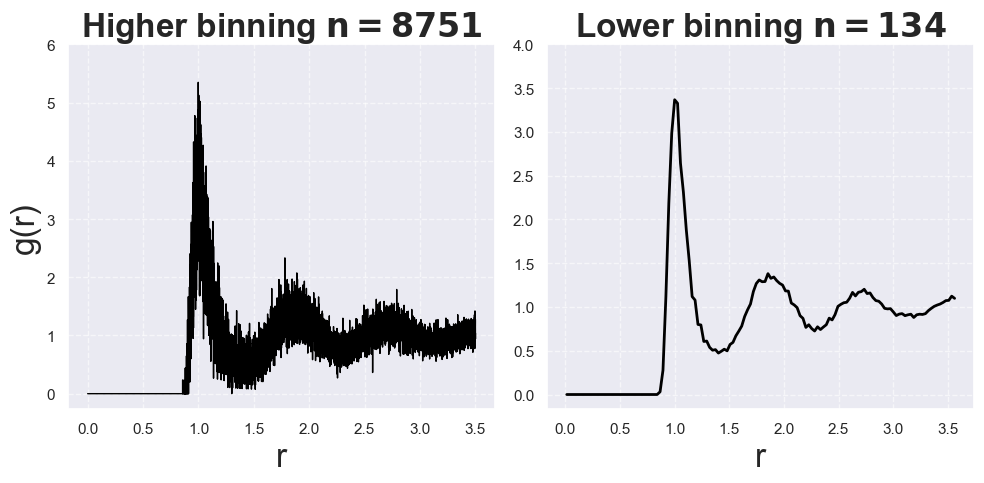

In [147]:
# We plot the RDF values side by side

sns.set()
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(data[0][:,0], data[0][:,1],  color='black', linestyle='-', linewidth=1)
ax[0].set_xlabel('r', fontsize=24)
ax[0].set_ylim(None, 6)
ax[0].set_ylabel(r'g(r)', fontsize=24)
ax[0].set_title(r'Higher binning $\mathbf{n=8751}$', fontsize=24, fontweight='bold')




ax[1].plot(data[1][:,0], data[1][:,1], color='black', linestyle='-', linewidth=2)
ax[1].set_xlabel('r', fontsize=24)
ax[1].set_ylim(None, 4)


ax[1].set_title(r'Lower binning $\mathbf{n=134}$', fontsize=24, fontweight='bold')
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[1].grid(True, linestyle='--', alpha=0.6)



plt.tight_layout()
plt.show()

In [148]:
# Initialize arrays 
RDF = [data[0][:,1], data[1][:,1]]
r = [data[0][:,0], data[1][:,0]]
num_bins = [RDF[0].shape[0], RDF[1].shape[0]]
del_r = [r[0][2]-r[0][1], r[1][2]-r[1][1]]

# System information 
total_particles = 2000
box_length = 12
density = total_particles/box_length**3

In [149]:
### This is an optimized but equilvalent version of constructing the T1, T2, and T3 matrix ###

def compute_T1(delr, Nbins):
    """
    Args:
        delr (float): bin width
        Nbins (int): number of bins

    Returns:
        T1 (array): T1 matrix of size Nbins x Nbins
    """
    T1 = np.zeros((Nbins,Nbins)) 
    for col in range(1, Nbins): # First column is all zeros
        value = (col*delr)**2
        T1[col, col] = value
        T1[col+1:, col] = 2*value
    return T1

def compute_T2(delr, Nbins, w):
    """
    Args:
        delr (float): bin width
        Nbins (int): number of bins

    Returns:
        T2 (array): T2 matrix of size Nbins x Nbins
    """
    m_KL = np.ceil(2*w/delr).astype(int) # number of bins to average over
    k_KL = 2*m_KL-1
    fractions = np.zeros((1,k_KL))
    A1_block = sp.identity(m_KL, format='csr')
    A2_block = sp.lil_matrix((m_KL, Nbins-m_KL))
    fractions[0,m_KL-1:] = norm.cdf(((np.arange(0,m_KL)+0.5)*delr),0,w)-norm.cdf(((np.arange(0,m_KL)-0.5)*delr),0,w)        
    fractions[0,:m_KL-1] = np.flip(fractions[0,m_KL:2*m_KL-1])
    fractions[0, :] *= 1/np.sum(fractions)
    B_block = sp.diags(np.tile(fractions, (Nbins-2*m_KL, 1)).T, np.arange(0, 2*(m_KL-1)+1), shape=(Nbins-2*m_KL, Nbins))
    T2 = sp.vstack((sp.hstack((A1_block, A2_block)), B_block, sp.hstack((A2_block, A1_block))))
    return T2

def compute_T3(delr, Nbins):
    """
    Args:
        delr (float): bin width
        Nbins (int): number of bins
        density (float): density of the system

    Returns:
        T3 (array): T3 matrix of size Nbins x Nbins
    """
    T3 = np.zeros((Nbins,Nbins))
    constant = 1/(delr**2)
    for row in range(1, Nbins):
        T3[row, row] = constant/(row)**2
        factor = 2*constant/(row)**2
        sign = 1 - 2 * (row & 1)
        for col in range(row):
            T3[row, col] = sign*factor
            sign *= -1
    return T3


In [150]:
Nr_raw = []
for i, Nbins in enumerate(num_bins):
    T1 = compute_T1(del_r[i], Nbins)
    T1 *= 2*np.pi*density*del_r[i]
    Nr_raw.append(T1@RDF[i])

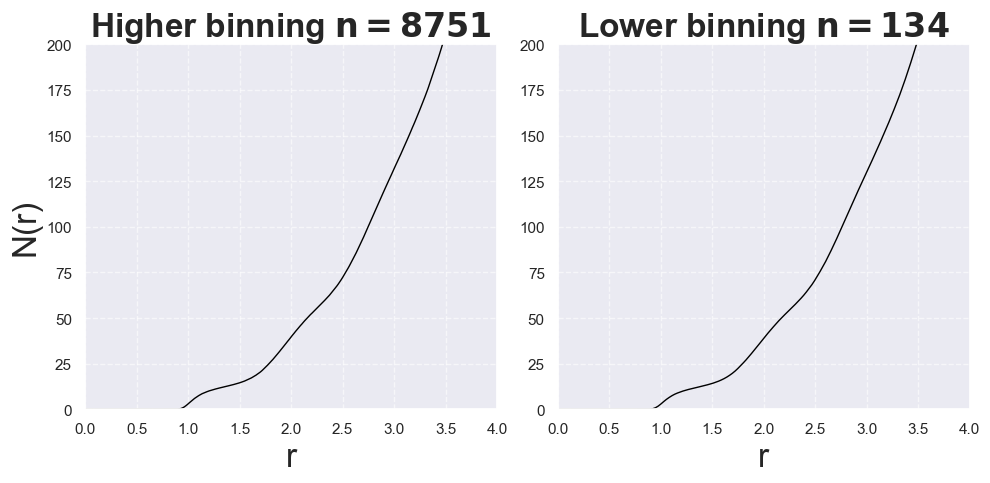

In [151]:
# Now we plot the raw N1 values
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(r[0], Nr_raw[0],  color='black', linestyle='-', linewidth=1)
ax[0].set_xlabel('r', fontsize=24)
ax[0].set_ylabel(r'N(r)', fontsize=24)
ax[0].set_ylim(0, 200)
ax[0].set_xlim(0,4)
ax[0].set_title(r'Higher binning $\mathbf{n=8751}$', fontsize=24, fontweight='bold')
ax[1].plot(r[1], Nr_raw[1], color='black', linestyle='-', linewidth=1)
ax[1].set_xlabel('r', fontsize=24)
ax[1].set_ylim(0, 200)
ax[1].set_xlim(0,4)
ax[1].set_title(r'Lower binning $\mathbf{n=134}$', fontsize=24, fontweight='bold')
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[1].grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [152]:
w = 0.015
Nr_convert = []
m_KLs = []

for i, Nbins in enumerate(num_bins):
    m_KL = np.ceil(2*w/del_r[i]).astype(int) # number of bins to average over
    T2 = compute_T2(del_r[i], Nbins, w)
    Nr_convert.append(T2@Nr_raw[i])
    m_KLs.append(m_KL)

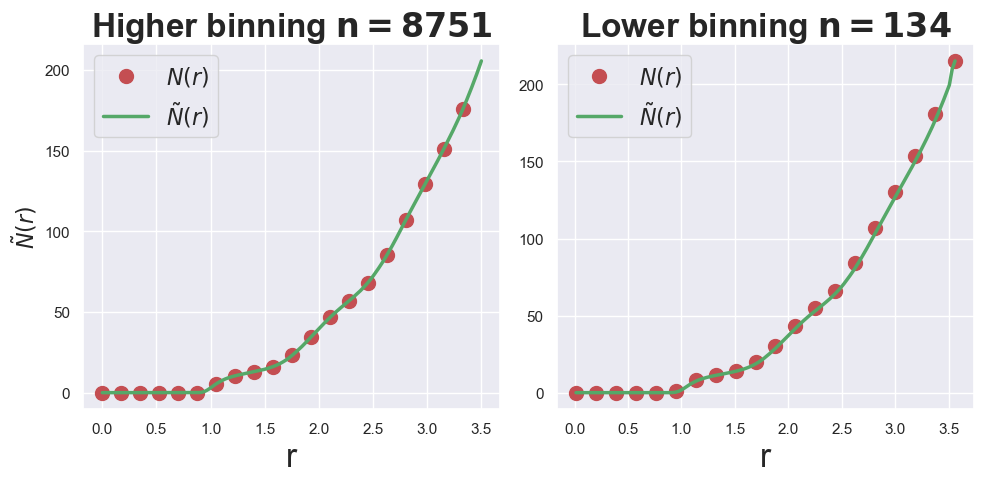

In [153]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(r[0][0::int(np.ceil(0.05 * num_bins[0]))], Nr_raw[0][0::int(np.ceil(0.05 * num_bins[0]))], 'ro', markersize=10)
ax[0].plot(r[0], Nr_convert[0], 'g-', linewidth=2.5)
ylabel_name = f'$\\tilde N(r)$'
ax[0].set_xlabel('r', fontsize=24)
ax[0].set_ylabel(ylabel_name, fontsize=16)
legend_labels = [f'$N(r)$', f'$\\tilde N(r)$']
ax[0].legend(legend_labels, fontsize=16)


ax[0].set_title(r'Higher binning $\mathbf{n=8751}$', fontsize=24, fontweight='bold')
ax[1].plot(r[1][0::int(np.ceil(0.05 * num_bins[1]))], Nr_raw[1][0::int(np.ceil(0.05 * num_bins[1]))], 'ro', markersize=10)
ax[1].plot(r[1], Nr_convert[1], 'g-', linewidth=2.5)
ax[1].set_xlabel('r', fontsize=24)
legend_labels = [f'$N(r)$', f'$\\tilde N(r)$']
ax[1].legend(legend_labels, fontsize=16)
ax[1].set_title(r'Lower binning $\mathbf{n=134}$', fontsize=24, fontweight='bold')
plt.tight_layout()


plt.show()



In [184]:
# Now we calculate g(r) tilde 
gr_converts = []
for i, Nbins in enumerate(num_bins):
        T3 = compute_T3(del_r[i], Nbins)
        gr_convert = T3@Nr_convert[i]
        gr_convert /= 2.*np.pi*density*del_r[i]
        gr_converts.append(gr_convert)

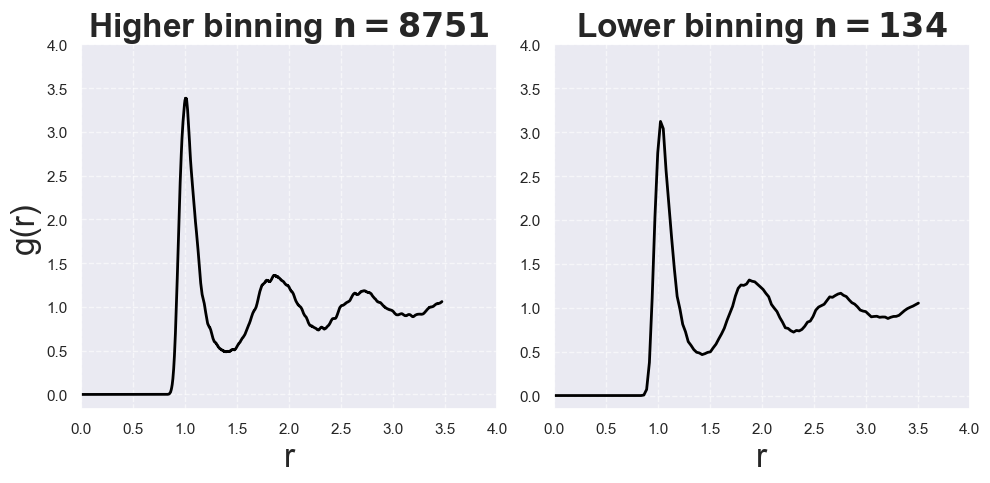

In [185]:
# Now we plot gr_converts against raw gr values 
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(r[0][:-m_KLs[0]], gr_converts[0][:-m_KLs[0]],  color='black', linestyle='-', linewidth=2)
ax[0].set_xlabel('r', fontsize=24)
ax[0].set_ylabel(r'g(r)', fontsize=24)
ax[0].set_ylim(None, 4)
ax[0].set_xlim(0,4)
ax[0].set_title(r'Higher binning $\mathbf{n=8751}$', fontsize=24, fontweight='bold')
ax[1].plot(r[1][:-m_KLs[1]], gr_converts[1][:-m_KLs[1]], color='black', linestyle='-', linewidth=2)
ax[1].set_xlabel('r', fontsize=24)
ax[1].set_ylim(None, 4)
ax[1].set_xlim(0,4)
ax[1].set_title(r'Lower binning $\mathbf{n=134}$', fontsize=24, fontweight='bold')
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[1].grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()






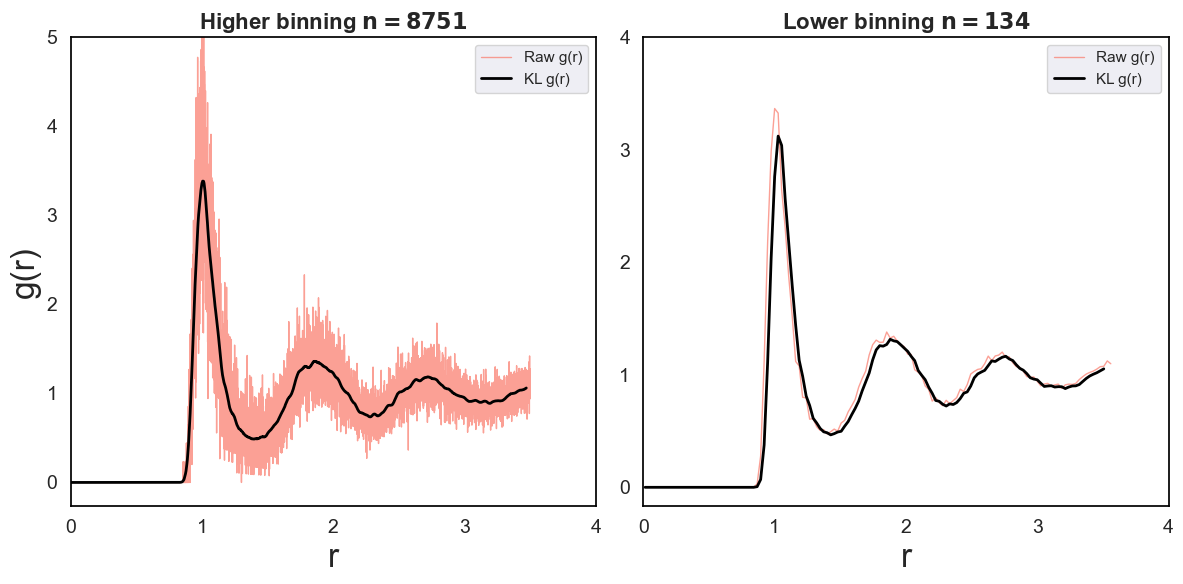

In [198]:
# Now we compare these to the raw values 
# Now we plot gr_converts against raw gr values 
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(r[0], RDF[0],  color='salmon', linestyle='-', linewidth=1, label='Raw g(r)', alpha=0.75)
ax[0].plot(r[0][:-m_KLs[0]], gr_converts[0][:-m_KLs[0]],  color='black', linestyle='-', linewidth=2, label='KL g(r)')
ax[0].set_xlabel('r', fontsize=24)
ax[0].set_ylabel(r'g(r)', fontsize=24)
ax[0].set_ylim(None, 5)
ax[0].set_xlim(0,4)
ax[0].set_xticks(np.arange(0, 5, 1))
ax[0].set_yticks(np.arange(0, 6, 1))
ax[0].set_title(r'Higher binning $\mathbf{n=8751}$', fontsize=16, fontweight='bold')
ax[1].plot(r[1], RDF[1], color='salmon', linestyle='-', linewidth=1, label='Raw g(r)', alpha=0.75)
ax[1].plot(r[1][:-m_KLs[1]], gr_converts[1][:-m_KLs[1]], color='black', linestyle='-', linewidth=2, label='KL g(r)')
ax[1].set_xlabel('r', fontsize=24)
ax[1].set_ylim(None, 4)
ax[1].set_xlim(0,4)
# Set xticks 
ax[1].set_xticks(np.arange(0, 5, 1))
ax[1].set_yticks(np.arange(0, 5, 1))
# Set tick size to 16
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)

# Set background to white 
ax[0].set_facecolor('white')
ax[1].set_facecolor('white')

# Dont white out axis lines 
ax[0].spines['bottom'].set_color('black')
ax[0].spines['top'].set_color('black')

ax[0].spines['right'].set_color('black')
ax[0].spines['left'].set_color('black')

ax[1].spines['bottom'].set_color('black')
ax[1].spines['top'].set_color('black')

ax[1].spines['right'].set_color('black')
ax[1].spines['left'].set_color('black')



ax[1].set_title(r'Lower binning $\mathbf{n=134}$', fontsize=16, fontweight='bold')
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()


In [157]:
idx_min = np.argmin(del_r)
idx_max = np.argmax(del_r)
m_KL = m_KLs[idx_min]
gr_raw_interp = np.interp(r[idx_min], r[idx_max], RDF[idx_max])
gr_KL_intrerp = np.interp(r[idx_min], r[idx_max], gr_converts[idx_max])

# Now we plot the ratio and differences between raw and KL data 
diff_raw = gr_raw_interp - RDF[idx_min]
diff_KL = gr_KL_intrerp - gr_converts[idx_min]
diff_KL = diff_KL[:-m_KL]
ratio_raw = gr_raw_interp/RDF[idx_min]
ratio_KL = gr_KL_intrerp/gr_converts[idx_min]
ratio_KL = ratio_KL[:-m_KL]

/var/folders/fl/w5ry88r17k36zgmfz_00htzh0000gn/T/ipykernel_43439/4200515757.py:11: RuntimeWarning: divide by zero encountered in divide
  ratio_raw = gr_raw_interp/RDF[idx_min]
/var/folders/fl/w5ry88r17k36zgmfz_00htzh0000gn/T/ipykernel_43439/4200515757.py:11: RuntimeWarning: invalid value encountered in divide
  ratio_raw = gr_raw_interp/RDF[idx_min]
/var/folders/fl/w5ry88r17k36zgmfz_00htzh0000gn/T/ipykernel_43439/4200515757.py:12: RuntimeWarning: invalid value encountered in divide
  ratio_KL = gr_KL_intrerp/gr_converts[idx_min]


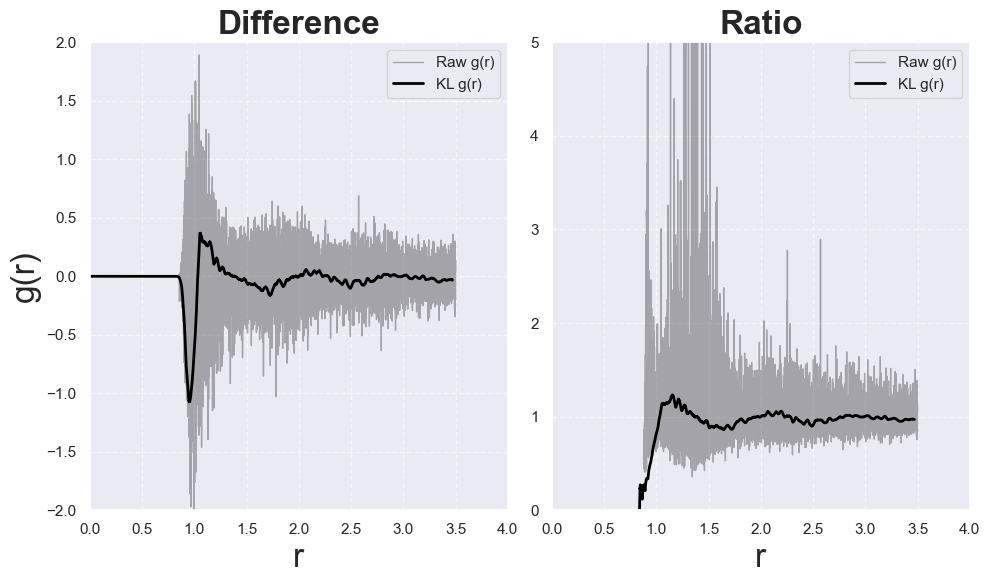

In [158]:
# Now we plot the ratio and differences between raw and KL data
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(r[idx_min], diff_raw,  color='black', linestyle='-', linewidth=1, label='Raw g(r)', alpha=0.3)
ax[0].plot(r[idx_min][:-m_KL], diff_KL,  color='black', linestyle='-', linewidth=2, label='KL g(r)')
ax[0].set_xlabel('r', fontsize=24)
ax[0].set_ylabel(r'g(r)', fontsize=24)
ax[0].set_ylim(-2, 2)
ax[0].set_xlim(0,4)
ax[0].set_title('Difference', fontsize=24, fontweight='bold')
ax[1].plot(r[idx_min], ratio_raw, color='black', linestyle='-', linewidth=1, label='Raw g(r)', alpha=0.3)
ax[1].plot(r[idx_min][:-m_KL], ratio_KL, color='black', linestyle='-', linewidth=2, label='KL g(r)')
ax[1].set_xlabel('r', fontsize=24)
ax[1].set_ylim(0, 5)
ax[1].set_xlim(0,4)
ax[1].set_title('Ratio', fontsize=24, fontweight='bold')
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.show()